In [26]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1.3)

from agents import Agent
from mouselab import MouselabEnv
from distributions import Normal, Categorical
from policies import FixedPlanPolicy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
def make_env(depth, cost, ground_truth):
    reward = Categorical([-1, 1])
    env = MouselabEnv(2, depth, reward=reward, cost=cost)
    if ground_truth:
        env.ground_truth = np.array([0, *reward.sample(len(env.tree) - 1)])
    return env

def make_envs(depth=3, cost=.1, seed=0, n=100, ground_truth=False):
    np.random.seed(seed)
    if ground_truth:
        return [make_env(depth, cost, True) for _ in range(n)]
    else:
        return [make_env(depth, cost, False)] * n

In [28]:
agent = Agent()
def run_env(policy, env):
    agent.register(policy)
    agent.register(env)
    tr = agent.run_episode()
    return {'util': tr['return'],
            'observations': len(tr['actions']) - 1}

def evaluate(policy, envs):
    return pd.DataFrame(run_env(policy, env) for env in envs)

In [29]:
import time
def timed(method):

    def dec(*args, **kw):
        ts = time.time()
        result = method(*args, **kw)
        te = time.time()

        print('%r %2.2f sec' % (method.__name__, te-ts))
        return result

    return dec

In [164]:
from policies import MouselabPolicy
from skopt import gp_minimize

def x2theta(x):
    assert len(x) == 4
    cost_weight = x[0]
    voi_weights = np.array(x[1:])
    # voi_weights /= voi_weights.sum()
    term_weight = 1
    return np.array([cost_weight, *voi_weights, term_weight])
    
@timed
def bo_policy(envs, n_calls=60, verbose=False):
    bounds = [ (1., 3.)] + [ (0., 1.) ] * 3
    # bounds = [(-10., 10.)] * 4
    def objective(x):
        theta = x2theta(x)
        util = evaluate(MouselabPolicy(theta), envs).util.mean()
        if verbose:
            print(theta.round(3), util)
        # regularize = 0.01 * (theta ** 2).sum()
        regularize = 0
        return - (util - regularize)
    
    result = gp_minimize(objective, bounds, n_calls=n_calls, random_state=0)
    theta = x2theta(result.x)
    print('theta:', theta.round(3))
    return MouselabPolicy(theta)

In [162]:
from exact import solve
from policies import FunctionPolicy
@timed
def optimal_policy(env):
    Q, V, pi, info = solve(env, hash_state='sort_tree')
    policy = FunctionPolicy(pi)
    return policy, V(env.init)

In [166]:
def data():
    def dfs():
        for cost in np.logspace(-7, 0, 8, base=2):
            print('cost', cost)
            train_envs = make_envs(depth=3, cost=cost, n=500)
            term = train_envs[0].term_action
            opt_policy, opt_util = optimal_policy(train_envs[0])
            policies = {
                'BO': bo_policy(train_envs, n_calls=80),
                'myopic': MouselabPolicy([1, 1, 0, 0, 1]),
                # 'optimal': opt_policy,
                'full': FixedPlanPolicy(range(1, term+1)),
                'none': FixedPlanPolicy([term]),
                # 'one': FixedPlanPolicy([1, 5, 9, 13, TERM]),
                # 'two': FixedPlanPolicy([1, 2, 5, 6, 9, 10, 13, 14, TERM]),
            }
            eval_envs = make_envs(depth=3, cost=cost, n=500)
            for name, policy in policies.items():
                df = evaluate(policy, envs=eval_envs)
                df['agent'] = name
                df['cost'] = cost
                # print('======= {} ======='.format(name))
                # print('Observations: {:.3f}'.format(df.observations.mean() - 2))
                # print('Return: {:.3f}'.format(df.util.mean() / sigma))
                yield df
            yield pd.DataFrame([{'cost': cost, 'agent': 'exact_optimal', 'util': opt_util}])
    return pd.concat(dfs())

df = data()
# sns.factorplot('cost', 'util', hue='agent', data=df)

cost 0.0078125
'optimal_policy' 98.84 sec
theta: [ 10.      6.939   7.389  10.      1.   ]
'bo_policy' 201.34 sec
cost 0.015625
'optimal_policy' 74.12 sec
theta: [ 10.     10.     10.      6.095   1.   ]
'bo_policy' 184.34 sec
cost 0.03125
'optimal_policy' 72.99 sec
theta: [  9.953  10.      5.213   3.656   1.   ]
'bo_policy' 166.17 sec
cost 0.0625
'optimal_policy' 82.38 sec
theta: [ 0.023  3.042  3.053  0.343  1.   ]
'bo_policy' 161.12 sec
cost 0.125
'optimal_policy' 71.25 sec
theta: [  2.832   3.423  10.     -0.544   1.   ]
'bo_policy' 155.27 sec
cost 0.25
'optimal_policy' 69.90 sec
theta: [  4.313  10.      3.012  -0.748   1.   ]
'bo_policy' 142.43 sec
cost 0.5
'optimal_policy' 74.46 sec
theta: [  8.303  10.     -1.28    1.734   1.   ]
'bo_policy' 97.29 sec
cost 1.0
'optimal_policy' 75.31 sec
theta: [ 9.273 -2.331  5.835  0.578  1.   ]
'bo_policy' 101.29 sec


(-2, 2)

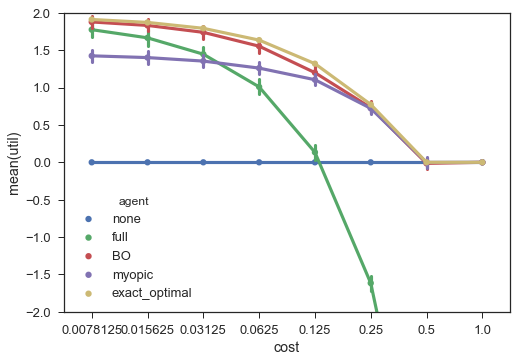

In [167]:
sns.set_style('ticks')
sns.pointplot('cost', 'util', hue='agent', data=df, markers='.', size=(4,4), )
plt.ylim(-2, 2)

(-2, 2)

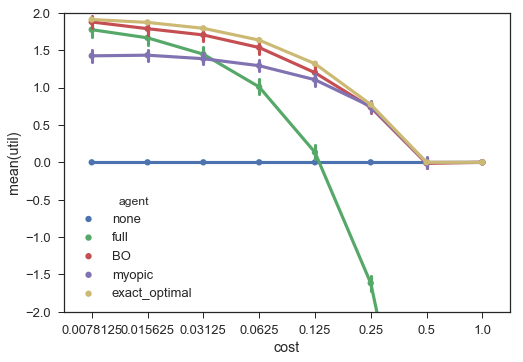

In [151]:
sns.set_style('ticks')
sns.pointplot('cost', 'util', hue='agent', data=df, markers='.', size=(4,4), )
plt.ylim(-2, 2)

# Regression

In [110]:
from collections import defaultdict
from toolz import memoize
from exact import sort_tree

def hash_key(args, kwargs):
    s = args[0]
    if s is None:
        return s
    else:
        return sort_tree(env, s)
    
def regression_data(env):
    Q, V, pi, info = solve(env, hash_state='sort_tree')
    data = []
    @memoize(key=hash_key)
    def rec(s):
        for a in env.actions(s):
            for p, s1, r in env.results(s, a):
                data.append({
                    'features': env.action_features(a, state=s),
                    'state': s,
                    'action': a,
                    'q_star': Q(s, a)
                })
                rec(s1)
    rec(env.init)
    return pd.DataFrame(data)


def big_regression():
    for cost in np.logspace(-2.5, 0.5, 5):
        env = make_env(2, cost, None)
        df = pd.DataFrame(regression_data(env))
        yield df

big = pd.concat(big_regression())

In [135]:
from sklearn.linear_model import LinearRegression

def run_regression(df):
    X = np.stack(df.features)
#     X[:, 0] = 1
#     X[:, -1] = 1
    m = LinearRegression().fit(X, df.q_star)
    df['q_hat'] = m.predict(X)
    df['abs_error'] = np.abs(df['q_hat'] - df['q_star'])
    return m.coef_

print(run_regression(df))
df.abs_error.mean()

[ 0.     0.221  0.042  0.656  0.992]


0.03331159391534972

In [90]:
features = [
    'cost',
    'myopic_voc',
    'vpi_action',
    'vpi',
    'expected_term_reward',
]

def data():
    for cost in np.logspace(-2.5, 0.5, 5):
        env = make_env(2, cost, None)
        df = pd.DataFrame(regression_data(env))
        yield [cost, *run_regression(df)]

coefs = pd.DataFrame(data())
coefs.columns = ['COST', *features]
coefs = coefs.set_index('COST')

coefs.plot(logx=True)
plt.plot(coefs[['myopic_voc', 'vpi_action', 'vpi']].sum(axis=1), c='k', ls='--', 
         label='myopic_voc + vpi_action + vpi')
plt.legend()